# #06: Working with Boolean Networks

While previous tutorials focused on individual Boolean functions, this tutorial
introduces Boolean networks, which combine multiple Boolean functions into a
dynamical system.

## What you will learn
In this tutorial you will learn how to:

- create Boolean networks,
- compute basic properties of the wiring diagram,
- compute basic properties of Boolean networks.

---
## 0. Setup

In [1]:
import boolforge
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

---
## 1. Boolean network theory

A Boolean network $F = (f_1, \ldots, f_N)$ is a dynamical system consisting of
$N$ Boolean update functions. Each node can be in one of two states, 0 or 1,
often interpreted as OFF/ON in biological contexts.

Under synchronous updating, all nodes update simultaneously, yielding a
deterministic state transition graph on $\{0,1\}^N$.

Under asynchronous updating, only one node is updated at a time, yielding a
stochastic transition graph. BoolForge implements both schemes.

Real biological networks are typically sparsely connected. The **in-degree**
of a node is the number of essential inputs of its update function. The
**wiring diagram** encodes which nodes regulate which others.

Despite their simplicity, Boolean networks can:
- reproduce complex dynamics (oscillations, multistability),
- predict gene knockout effects,
- identify control strategies,
- scale to genome-wide networks (1000s of nodes).

---
## 2. Wiring diagrams

We first construct wiring diagrams, which encode network structure independently
of specific Boolean functions.

Separating topology (I) from dynamics (F) allows:
- studying structural properties independent of specific Boolean rules,
- swapping different rule sets on the same topology,
- efficient storage (sparse I, local F vs dense full truth table).

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [1 2 1]
W.outdegrees: [1 2 1]


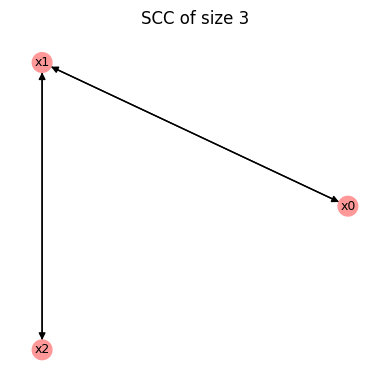

In [2]:
# Wiring diagram of a 3-node network
I = [
    [1],
    [0, 2],
    [1],
]

W = boolforge.WiringDiagram(I=I)

print("W.N:", W.N)
print("W.variables:", W.variables)
print("W.indegrees:", W.indegrees)
print("W.outdegrees:", W.outdegrees)

W.plot();

The wiring diagram above uses default variable names $x_0, \ldots, x_{N-1}$.
The vectors `indegrees` and `outdegrees` describe incoming and outgoing edges
for each node.

### Example with constants and unequal degrees

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [0 2 1]
W.outdegrees: [2 0 1]


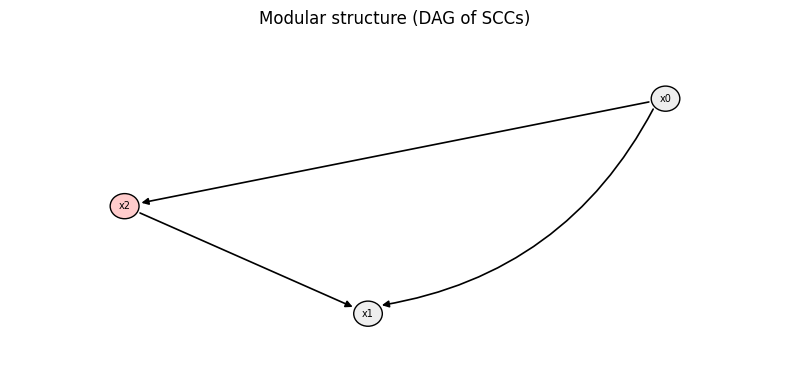

In [3]:
I = [
    [],
    [0, 2],
    [0],
]

W = boolforge.WiringDiagram(I=I)

print("W.N:", W.N)
print("W.variables:", W.variables)
print("W.indegrees:", W.indegrees)
print("W.outdegrees:", W.outdegrees)

W.plot();

This wiring diagram encodes a **feed-forward loop**, one of the most common *network motifs* in 
transcriptional networks. It can:
- filter transient signals (coherent FFL with AND gate),
- accelerate response (incoherent FFL),

See Mangan & Alon, PNAS, 2003 for a detailed analysis.
`BoolForge` enables the identification of all feed-forward loops:

In [4]:
print("W.get_ffls()", W.get_ffls())

W.get_ffls() {'FFLs': [[0, 2, 1]]}


This tells us that `W` contains one FFL, in which $x_0$ regulates both $x_1$ and $x_2$, 
while $x_1$ is also regulated by $x_2$.

`BoolForge` can also identify all feedback loops. For this, we consider another wiring diagram:

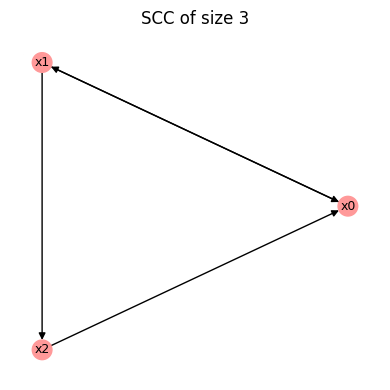

W2.get_fbls() {'FBLs': [[0, 1, 2], [0, 1]]}


In [5]:
I2 = [
    [2,1],
    [0],
    [1],
]

W2 = boolforge.WiringDiagram(I=I2)
W2.plot();

print("W2.get_fbls()", W2.get_fbls())

The function `.get_fbls()` identifies all simple cycles in the wiring diagram. 
In this case, there exists a 2-cycle $x_0 \leftrightarrow x_1$ and a 3-cycle $x_0 \to x_1 \to x_2 \to x_0$.

---
## 3. Creating Boolean networks

To create a Boolean network, we must specify:

1. A wiring diagram `I`, describing who regulates whom.
2. A list `F` of Boolean update functions (or truth tables), one per node.

In [6]:
I = [
    [1],
    [0, 2],
    [1],
]

F = [
    [0, 1],
    [0, 1, 1, 1],
    [0, 1],
]

bn = boolforge.BooleanNetwork(F=F, I=I)

bn.to_truth_table()

,x0(t),x1(t),x2(t),x0(t+1),x1(t+1),x2(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


The full truth table of a Boolean network has size $N \times 2^N$ and therefore grows exponentially with the number of nodes.  
In practice, however, `BoolForge` never stores this object explicitly. 
Instead, a Boolean network is represented internally by its wiring diagram `I` and the list of update functions `F`, 
which is far more memory-efficient – especially for sparse networks with few regulators per node.

When a Boolean network is constructed from `F` and `I`, 
`BoolForge` automatically performs a series of consistency checks to guard against common modeling errors. 
For example, it verifies that each update function has the correct length, 
namely $2^n$, where $n$ is the number of regulators of the corresponding node as specified in `I`. 
If any of these checks fail, an informative error is raised immediately, 
helping ensure that the resulting network is well-defined.



### Creating networks from strings

Alternatively, Boolean networks can be specified using a human-readable
string representation, where each line defines the update rule of one node.
This format closely mirrors the way Boolean models are written in the literature
and is often more convenient than manually specifying wiring diagrams and
truth tables.

In the example below, each line has the form $x_i = f_i(\text{regulators of } x_i),$
where Boolean operators such as `AND`, `OR`, and `NOT` can be used to define
the update functions.

In [7]:
string = """
x = y
y = x OR z
z = y
"""

bn_str = boolforge.BooleanNetwork.from_string(string, separator="=")
bn_str.to_truth_table()

,x(t),y(t),z(t),x(t+1),y(t+1),z(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


Here, the update rule `x = y` specifies that node `x` copies the state of `y`,
while `y = x OR z` indicates that node `y` is regulated by both `x` and `z`.
From this symbolic description, `BoolForge` automatically:

- extracts the wiring diagram,
- determines the regulators of each node,
- constructs the corresponding Boolean update functions.

Internally, the string representation is converted into the same `(F, I)`
representation used throughout the package. As a result, Boolean networks
created from strings behave identically to those created explicitly from
wiring diagrams and truth tables.

This interface is particularly useful for loading Boolean network models from
external sources, such as `.bnet` files, or for quickly prototyping models in
an interactive setting.



### Interoperability with CANA

`BoolForge` provides native interoperability with
the `CANA` package for the analysis of Boolean functions and Boolean networks.
Existing `BoolForge` networks can be converted into CANA objects and back
without loss of information.

In the example below, we convert a `BoolForge` Boolean network into its CANA
representation using `to_cana()`, and then reconstruct a new `BoolForge`
Boolean network from that CANA object.

The final assertion verifies that this round-trip conversion preserves:

- the Boolean update functions,
- the wiring diagram,
- and the variable names.

This guarantees that `BoolForge` and CANA can be used interchangeably within
a workflow, allowing users to leverage CANA’s analytical tools while
continuing to build and manipulate models using `BoolForge`.

In [8]:
cana_bn = bn.to_cana()
bn_from_cana = boolforge.BooleanNetwork.from_cana(cana_bn)

assert (
    np.all([np.all(bn.F[i].f == bn_from_cana.F[i].f) for i in range(bn.N)])
    and np.all([np.all(bn.I[i] == bn_from_cana.I[i]) for i in range(bn.N)])
    and np.all(bn.variables == bn_from_cana.variables)
), "BooleanNetwork CANA conversion failed"

---
## 4. Types of nodes in Boolean networks

Nodes in a Boolean network can be classified as follows:

- **Constant nodes**  
  Nodes with constant update functions (always 0 or always 1).
  These nodes act as parameters and are removed internally, with their values
  propagated through the network.

- **Identity nodes**  
  Nodes whose update function is the identity, i.e., $f(x_i) = x_i.$
  Their value is determined by the initial condition and remains constant over time.
  Identity nodes are retained as part of the Boolean network state. 
  They may be viewed as nodes with a self-loop and no other incoming edges.


- **Regulated nodes**  
  Nodes whose update functions depend on one or more other nodes.

In [9]:
F = [
    [0, 0, 0, 1],  # regulated
    [0, 1, 1, 1],  # regulated
    [0, 1],        # identity
    [0],           # constant
]

I = [
    [1, 2],        # regulated
    [0, 3],        # regulated
    [2],           # identity
    [],            # constant
]

bn = boolforge.BooleanNetwork(F, I)

print("bn.variables:", bn.variables)
print("bn.constants:", bn.constants)
print("bn.F:", bn.F)
print("bn.I:", bn.I)

bn.variables: ['x0' 'x1' 'x2']
bn.constants: {'x3': {'value': 0, 'regulatedNodes': ['x1']}}
bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[0, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]


The constant node is removed, and its value is propagated into downstream
update functions.

If we now change the value of the constant node from 0 to 1, the network is
constructed in the same way, and the constant value 1 is substituted directly
into all downstream update functions, before removal of the constant node.

As a result, the Boolean update functions of downstream nodes may simplify,
potentially reducing the number of regulators or changing the logical form
of the function. This illustrates how constant nodes act as parameters whose
values influence the effective dynamics of the network.

Importantly, this simplification is performed symbolically at construction
time and does not depend on the dynamical evolution of the network.

In [10]:
F = [
    [0, 0, 0, 1],
    [0, 1, 1, 1],
    [0, 1],
    [1],
]

I = [
    [1, 2],
    [0, 3],
    [2],
    [],
]

bn = boolforge.BooleanNetwork(F, I)

print("bn.F:", bn.F)
print("bn.I:", bn.I)
print("bn.variables:", bn.variables)

bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[1, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]
bn.variables: ['x0' 'x1' 'x2']


Although $x_1$ becomes fixed at 1 after one update, it is not treated as a
constant node. In `BoolForge`, constant nodes are identified by their update
functions (always 0 or always 1), not by their long-term dynamical behavior.
Since $x_1 = 0$ remains a valid initial condition, the node is retained as part
of the network state.

---
## 5. Boolean network properties

The class `BooleanNetwork` inherits basic structural properties and methods
from `WiringDiagram`. In particular, all graph-theoretic attributes of the
wiring diagram -- such as the number of nodes, in-degrees, and out-degrees -- are
directly accessible on a Boolean network object.

Moreover, `BooleanNetwork` inherits visualization utilities from
`WiringDiagram`, including methods for plotting the wiring diagram and its
modular structure, using `.plot()`. This allows users to inspect the topology of a Boolean
network independently of the specific update functions.

Beyond these inherited features, `BooleanNetwork` provides a rich collection
of additional methods for analyzing the dynamics, structure, and control
properties of Boolean networks. These include functionality for:

- computing fixed points and attractors,
- analyzing transient dynamics and state transition graphs,
- studying robustness and sensitivity to perturbations,
- performing node and edge interventions.

Many of these methods will be introduced and discussed in detail in the
following tutorials. Here, we focus only on a few basic and commonly used
properties.

bn.N: 3
bn.indegrees: [2 1 1]
bn.outdegrees: [1 1 2]
bn.variables: ['x0' 'x1' 'x2']


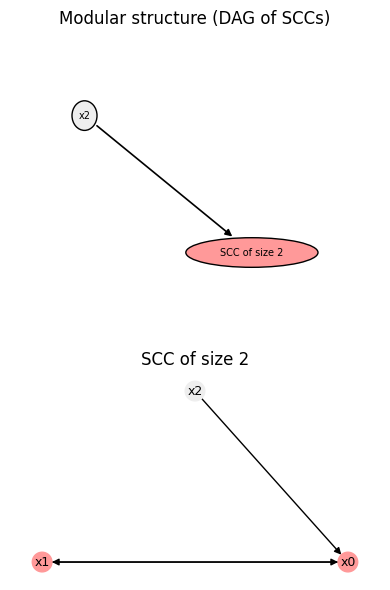

In [11]:
print("bn.N:", bn.N)
print("bn.indegrees:", bn.indegrees)
print("bn.outdegrees:", bn.outdegrees)
print("bn.variables:", bn.variables)

bn.plot();

---
## Outlook

In the remaining tutorials, we build on this foundation to study the dynamical
behavior of Boolean networks, including attractors, basins of attraction,
and stability under perturbations.